# WRDS Data Processing
We've got the data; now what cool stuff can we do?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import wrds
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df_devs = pd.read_csv('wrds_results/temp_deviations.csv',index_col=0)

In [105]:
temp_rankings = pd.DataFrame(columns=df_devs.columns)
temp_deciles = pd.DataFrame(columns=df_devs.columns)
replace_dict = {-1: np.nan, -1.0: np.nan}
for col in df_devs.columns:
    # reversing the argsort ensures the lowest volatility value gets rank 1
    argsorted = np.argsort(df_devs[col]).replace(replace_dict)[::-1]
    temp_rankings[col] = argsorted
    temp_deciles[col] = pd.qcut(df_devs[col], 10, labels=range(1, 11))

In [109]:
temp_deciles.iloc[0].dropna()

07/02/2001 - 12/31/2001     1
12/31/2001 - 07/01/2002     2
07/01/2002 - 12/30/2002     1
12/30/2002 - 06/30/2003     8
06/30/2003 - 12/29/2003     5
12/29/2003 - 06/28/2004     6
06/28/2004 - 01/03/2005     8
01/03/2005 - 06/27/2005    10
06/27/2005 - 01/02/2006     9
01/03/2006 - 07/03/2006     5
07/02/2007 - 12/31/2007     5
06/30/2008 - 12/29/2008     6
12/29/2008 - 06/29/2009     2
06/29/2009 - 01/03/2010     7
01/04/2010 - 06/28/2010     1
06/28/2010 - 01/03/2011     5
01/03/2011 - 06/27/2011     1
06/27/2011 - 01/02/2012     1
01/03/2012 - 07/02/2012     3
07/02/2012 - 12/31/2012     5
12/31/2012 - 07/01/2013     2
07/01/2013 - 12/30/2013     5
12/30/2013 - 06/30/2014     7
06/30/2014 - 12/29/2014     6
12/29/2014 - 06/29/2015     4
06/29/2015 - 01/03/2016     7
01/04/2016 - 06/27/2016     3
06/27/2016 - 01/02/2017    10
01/03/2017 - 07/03/2017     1
Name: 36720410, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [5]:
def get_rankings(recalc=True, waiting_period=0):
    # Generate/load devs, rankings, and deciles
    if recalc:
        df_devs = pd.read_csv('wrds_results/temp_deviations.csv', index_col=0)

        # remove the first *waiting_period* periods from each stock
        #   This both allows the volatility to stabilize, and (ideally) minimizes
        #   weird ranking jumps caused by stocks entering/exiting the market
            
        if waiting_period > 0:
            for i, row in df_devs.iterrows():
                idxs = row.dropna().index[:waiting_period]
                row[idxs] = np.nan
                
        df_devs = df_devs.dropna(axis='columns', how='all')

        # calculate rankings/deciles
        df_rankings = pd.DataFrame(columns=df_devs.columns)
        df_deciles = pd.DataFrame(columns=df_devs.columns)
        replace_dict = {-1: np.nan, -1.0: np.nan}
        for col in df_devs.columns:
            # reversing the argsort ensures the lowest volatility value gets rank 1
            argsorted = np.argsort(df_devs[col]).replace(replace_dict)[::-1]
            df_rankings[col] = argsorted
            df_deciles[col] = pd.qcut(df_devs[col], 10, labels=range(1, 11))

        # write rankings/deciles to file
        with open('wrds_results/rankings.csv', 'w') as file:
            df_rankings.to_csv(file)
        with open('wrds_results/deciles.csv', 'w') as file:
            df_deciles.to_csv(file)
            
        return pd.read_csv('wrds_results/temp_deviations.csv',index_col=0), df_rankings, df_deciles
    
    else:
        # load volatility, rankings, deciles, and period correlations dataframes from csv
        df_devs = pd.read_csv('wrds_results/temp_deviations.csv',index_col=0)
        df_rankings = pd.read_csv('wrds_results/rankings.csv', index_col=0)
        df_deciles = pd.read_csv('wrds_results/deciles.csv', index_col=0)
        period_corr = pd.read_csv('wrds_results/period_correlation.csv', index_col=0)
        
        return df_devs, df_rankings, df_deciles

In [6]:
df_devs, df_rankings, df_deciles = get_rankings(recalc=False, waiting_period=2)

### Checking the rankings
There seem to be some interesting issues with the rankings/deciles; there are a LOT of very surprising jumps, and I'd be very interested to understand why.

In [46]:
# generate dataframes with the differences between deciles/rankings
idx = df_devs.index
cols = df_devs.columns
n_cusips = len(df_devs)
n_pers = len(df_devs.columns) - 1

check_deciles = np.zeros((n_cusips, n_pers))
check_rankings = np.zeros((n_cusips, n_pers))
check_diffs = np.zeros((n_cusips, n_pers))
exits = np.zeros(n_pers)
entrances = np.zeros(n_pers)

for i in range(n_pers):
    check_deciles[:, i] = df_deciles.iloc[:, i + 1] - df_deciles.iloc[:, i]
    check_rankings[:, i] = df_rankings.iloc[:, i + 1] - df_rankings.iloc[:, i]
    check_diffs[:, i] = df_devs.iloc[:, i + 1] - df_devs.iloc[:, i]
    # obscene pythonic calculation to get around the fact that numpy and pandas don't
    #   agree on what a NaN value is apparently (otherwise this'd be more readable)
    changes = np.subtract(df_devs.iloc[:, i].isna().astype(np.float32), 
                                  df_devs.iloc[:, i + 1].isna().astype(np.float32))
    exits[i] = np.sum(changes > 0)
    entrances[i] = np.sum(changes < 0)

df_check_dec = pd.DataFrame(check_deciles, index=idx, columns=cols[:-1])
df_check_rank = pd.DataFrame(check_rankings, index=idx, columns=cols[:-1])
df_check_diffs = pd.DataFrame(check_diffs, index=idx, columns=cols[:-1])
exits = pd.Series(exits, index=cols[:-1])
entrances = pd.Series(entrances, index=cols[:-1])

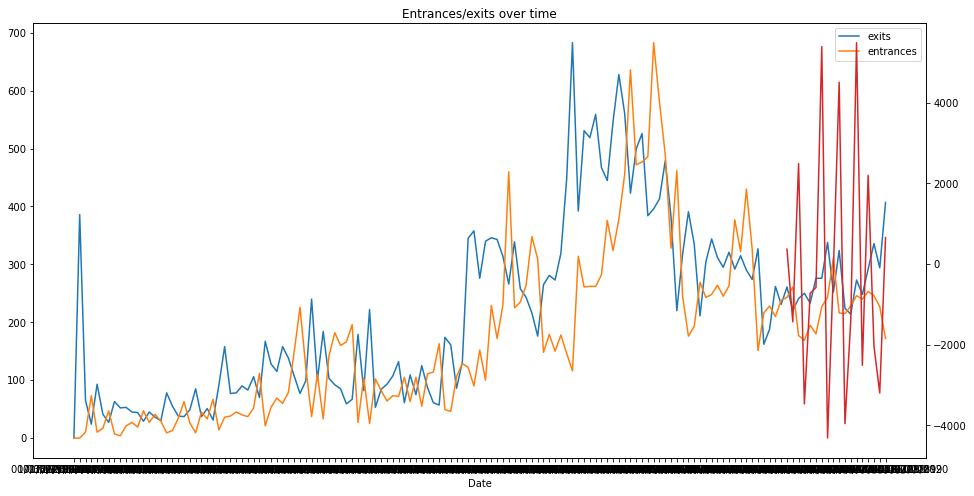

In [47]:
cusip = df_check_rank.index[0]
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(exits, label='exits')
ax.plot(entrances, label='entrances')
ax.twinx().plot(df_check_rank.loc[cusip], color='tab:red', label=cusip)
ax.set_title('Entrances/exits over time')
ax.set_xlabel('Date')
ax.legend()
plt.show()

In [48]:
cusips = df_check_diffs.index
pearsons = np.zeros((len(cusips), 2))
spearmans = np.zeros((len(cusips), 2))

for i, cusip in enumerate(cusips):
    rank_diffs = df_check_rank.loc[cusip].dropna()
    idx = rank_diffs.index
    if len(idx) > 1:
        pearsons[i] = [stats.pearsonr(rank_diffs, entrances[idx])[0], 
                       stats.pearsonr(rank_diffs, exits[idx])[0]]
        spearmans[i] = [stats.spearmanr(rank_diffs, entrances[idx])[0], 
                        stats.spearmanr(rank_diffs, exits[idx])[0]]

c:\users\kaih2\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\kaih2\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


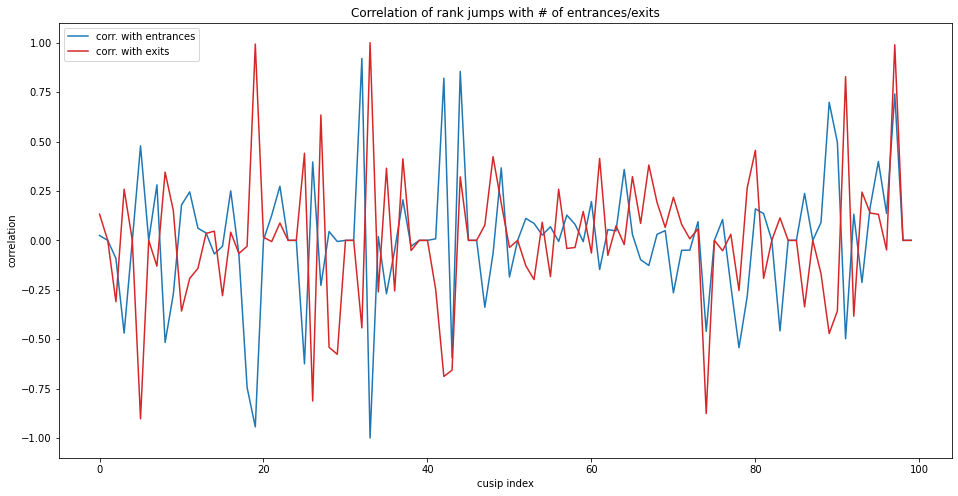

In [49]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(pearsons[:100, 0], color='tab:blue', label='corr. with entrances')
ax.plot(pearsons[:100, 1], color='tab:red', label='corr. with exits')
# ax.plot(abs(pearsons[:100, 0] - pearsons[:100, 1]), color='tab:purple', label='difference')
# ax.twinx().scatter(np.arange(50), 
#                    [max(df_check_rank.loc[cusip].dropna()) if len(df_check_rank.loc[cusip].dropna()) > 0 else 0 for cusip in cusips[:50]], 
#                    color='tab:orange')
ax.set_xlabel('cusip index')
ax.set_ylabel('correlation')
ax.set_title('Correlation of rank jumps with # of entrances/exits')
ax.legend()
plt.show()

In [167]:
# spearman & pearson correlations of 
df_pearson = pd.DataFrame(pearsons, index=cusips).dropna()
stats.spearmanr(df_pearson)[0], stats.pearsonr(df_pearson[0], df_pearson[1])[0]

(-0.5353429805876372, -0.5889537161623861)

#### Distributions of differences between consecutive periods

In [37]:
# check for normal distribution
checks = [df_check_diffs, df_check_dec, df_check_rank]
names = ['Volatility differences', 'Decile differences', 'Rank differences']
for i, array in enumerate(checks):
    print(names[i])
    vals = array.values.flatten()
    vals = vals[~np.isnan(vals)]
    unique_vals, counts = np.unique(vals, return_counts=True)
    mode_idx = np.argsort(counts)[-1]
    mode = unique_vals[mode_idx]
    mean = np.average(vals)
    median = np.median(vals)
    std = np.std(vals)
    std_dists = []
    for j in range(1, 4):
        bounds = [mean - j * std, mean + j * std]
        num_within_range = len([elt for elt in vals if elt >= bounds[0] and elt <= bounds[1]])
        std_dists.append(round(num_within_range / len(vals), 4))
    print(f' - Mean: {mean} \n - Median: {median} \n - Mode: {mode} \n' + 
          f' - STD: {std_dists[0]}/{std_dists[1]}/{std_dists[2]} within 1/2/3 standard devs ' + 
          f'(size {len(vals)}, {len(unique_vals)} unique vals)')

Volatility differences
 - Mean: 0.00029024762790612845 
 - Median: -0.0005000000000000004 
 - Mode: 0.0 
 - STD: 0.8535/0.9585/0.984 within 1/2/3 standard devs (size 438642, 13742 unique vals)
Decile differences
 - Mean: -0.030106556143734527 
 - Median: 0.0 
 - Mode: 0.0 
 - STD: 0.6003/0.9429/1.0 within 1/2/3 standard devs (size 438642, 21 unique vals)
Rank differences
 - Mean: 11.068739427596993 
 - Median: 14.0 
 - Mode: -6.0 
 - STD: 0.7007/0.9371/0.9996 within 1/2/3 standard devs (size 438642, 12194 unique vals)


In the cell above, I was trying to determine whether the distributions of the ranks/decile/volatility differences were normal, or whether they followed a different curve. Most of them seem to be relatively close to normal. The distribution of volatility differences seems to have a high proportion of values in the center (~85% within one std of the mean). I'm not sure whether this indicates it's not a normal distribution - maybe someone on the finance side of things can clarify this?

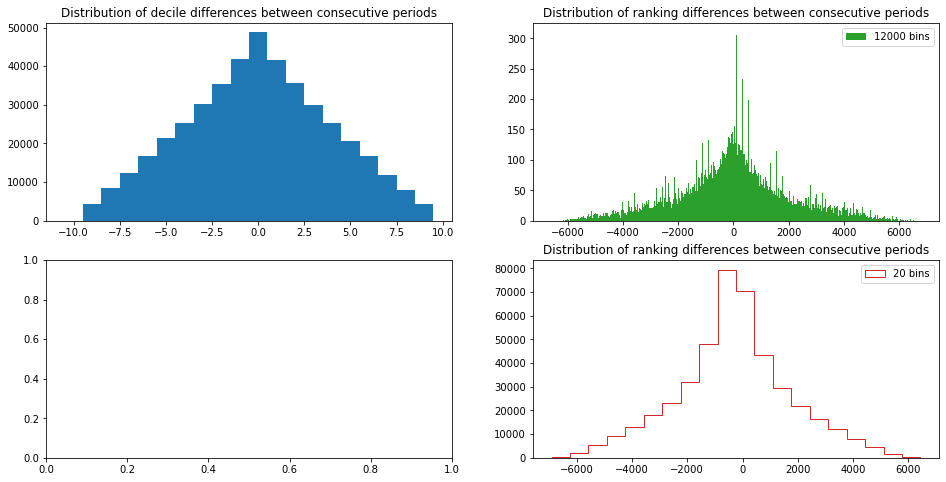

In [102]:
# mean = np.nanmean(np.abs(df_check), axis=0)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
axes[0][0].hist(df_check_dec.values.flatten(), bins=20,
             density=False, align='left')
axes[0][0].set_title('Distribution of decile differences between consecutive periods')

axes[0][1].hist(df_check_rank.values.flatten(), bins=12000,
             density=False, align='left', color='tab:green', label='12000 bins')
axes[1][1].hist(df_check_rank.values.flatten(), bins=20, histtype='step',
             density=False, align='left', color='tab:red', label='20 bins')
for i in range(2):
    axes[i][1].set_title('Distribution of ranking differences between consecutive periods')
    axes[i][1].legend()
plt.show()

### Entrances & Exits
In addition to a stock's actual volatility, rankings depend on the number of stocks which enter or exit in a given period. Initially, we'll just look at straight numbers, without considering individual stocks; later on, I'd like to look at the volatilities/rankings stocks enter/exit _with_.

In [73]:
# find the number of stocks which enter/exit in each period


### Jump sizes

In [6]:
jump_bound = 3
check_array = df_check_dec.loc['36720410'].dropna()
dates = (check_array > jump_bound).index
# df_check_diffs.loc['36720410'].loc[dates]

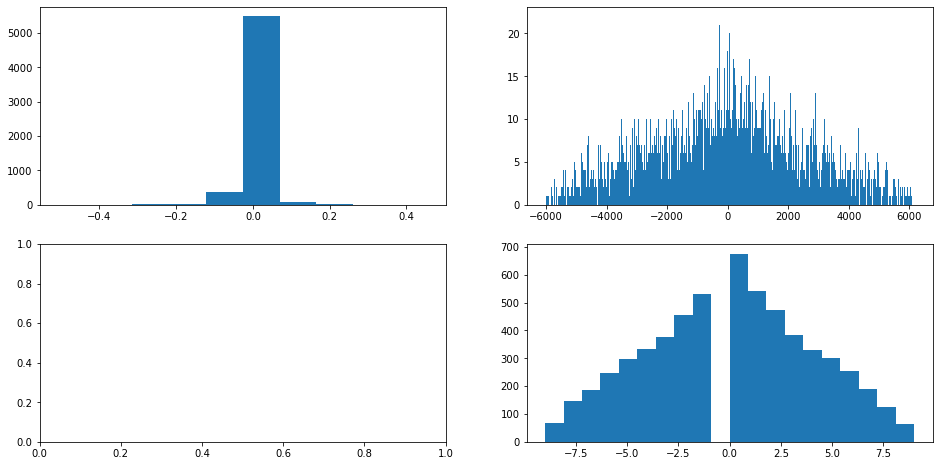

In [28]:
# bar chart of each stock's jumps for a given date
cusip = '36720410'
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

date = dates[8]
idx_of_int = df_check_diffs[date].index.tolist().index(cusip)
colors = ['tab:blue']*len(df_check_diffs[date])
colors[idx_of_int] = 'tab:red'
x = np.arange(len(df_check_diffs[date]))

axes[0][0].hist(df_check_diffs[date], bins=10)
axes[0][1].hist(df_check_rank[date], bins=1000)
axes[1][1].hist(df_check_dec[date], bins=20)
plt.show()

#### Stock data dropout & ranking difference over time

In [113]:
np.corrcoef(dropouts, df_check_dec.iloc[0])

array([[ 1., nan],
       [nan, nan]])

NameError: name 'dropouts' is not defined

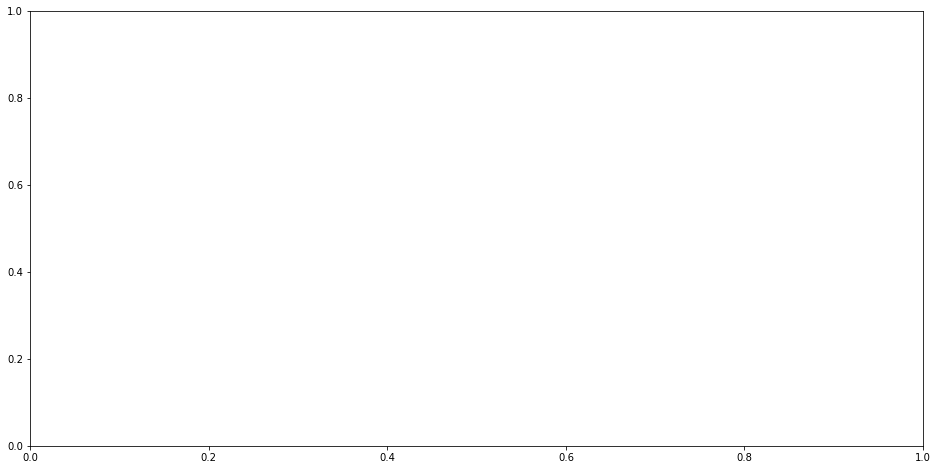

In [36]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(dropouts)
ax.twinx().plot(df_check_dec.iloc[0], color='tab:orange')
plt.show()

## Alignment to get volatility falloff per decade (á la Dr. Ikenberry)

In [85]:
# alignment (reshape data to get dropoff in correlation from "present")
decades = [10 * i for i in range(7)]
decade_avg_corrs = []
for i in range(7):
    # create aligned matrix for each decade
    new_mat = []
    for j, (_, row) in enumerate(period_corr.iloc[10 * i:10 * (i + 1)].iterrows()):
        row_list = row.to_list()
        new_mat.append(row_list[10 * i + j:])

    min_len = min([len(elt) for elt in new_mat])
    new_mat_array = np.array([elt[:min_len] for elt in new_mat])

    # get average correlations
    avgs = np.average(new_mat_array, axis=0)
    decade_avg_corrs.append(avgs)

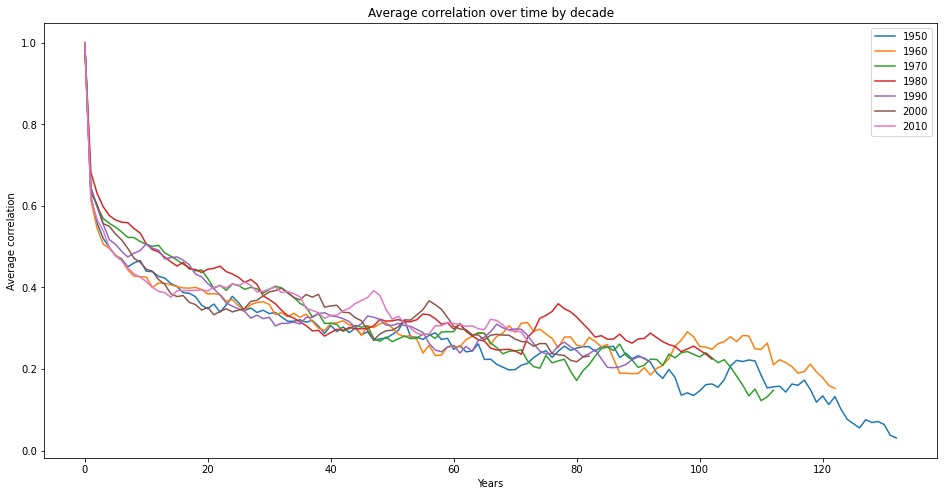

In [72]:
# plot results
fig, ax = plt.subplots(figsize=(16,8))
labels = [1950 + 10 * i for i in range(7)]
for i, decade in enumerate(decade_avg_corrs):
    ax.plot(decade, label=labels[i])
ax.legend()
ax.set_xlabel('Years')
ax.set_ylabel('Average correlation')
ax.set_title('Average correlation over time by decade')
plt.show()

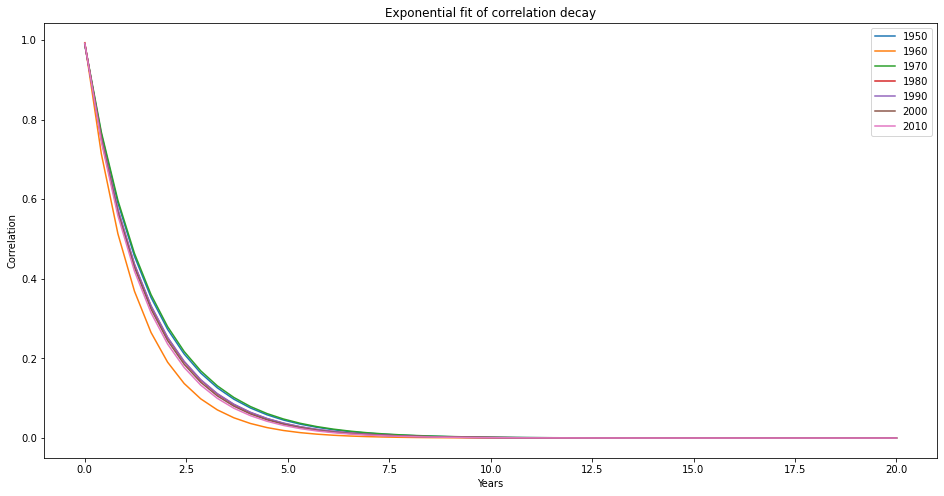

In [73]:
# fit an exponential curve to the correlation falloff for each decade
fig, ax = plt.subplots(figsize=(16,8))
decay_coeffs = []
for i, decade in enumerate(decade_avg_corrs):
    x = range(len(decade))
    args = np.polyfit(x, np.log(decade), 1) # disregard initial value of 1?
    decay_coeffs.append(np.exp(args[1]))
    x = np.linspace(0, 20)
    ax.plot(x, np.exp(args[0]) * (np.exp(args[1]) ** x), label=(1950 + i * 10))
ax.legend()
ax.set_xlabel('Years')
ax.set_ylabel('Correlation')
ax.set_title('Exponential fit of correlation decay')
plt.show()

In [12]:
decades_sorted = [1950 + i * 10 for i in np.argsort(decay_coeffs)[::-1]]
ranking_dict = dict(zip(decades_sorted, np.sort(decay_coeffs)[::-1]))
ranking_dict

{1970: 0.5385829665810147,
 1950: 0.5325417272923237,
 1990: 0.5126022956565282,
 1980: 0.510787792305298,
 2000: 0.5042275758407692,
 2010: 0.4948771655418226,
 1960: 0.44532686102405117}

## Markov modeling

In [26]:
# generates a transition matrix
#   matrix[i, j] represents the prob. of transitioning from state i to state j
#   (row -> column)
def generate_transition_mat(df):
    n_states = int(df.max().max()) + 1
    transition_mat = np.zeros((n_states, n_states))
    for i, row in df.iterrows():
        for j in range(len(row) - 1):
            elt = row[j]
            next_elt = row[j + 1]
            if (not np.isnan(elt)) and (not np.isnan(next_elt)):
                transition_mat[int(elt)][int(next_elt)] += 1
    
    for row in transition_mat:
        if np.sum(row) > 0:
            print(f'Current row: {row}')
            print(f'Row sum: {np.sum(row)}')
            row /= np.sum(row)
            print(f'Updated row: {row}')
            print('---------')
    
    return transition_mat

In [112]:
_, df_rankings, df_deciles = get_rankings(recalc=True, waiting_period=0)

In [113]:
decile_markov = generate_transition_mat(df_deciles)

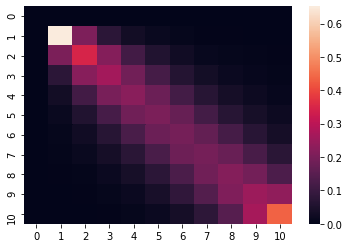

In [114]:
sns.heatmap(decile_markov)
plt.show()

In [30]:
decile_markov[:, 1]

array([0.        , 0.11152696, 0.10622132, 0.10253965, 0.10123023,
       0.09743861, 0.097231  , 0.09797135, 0.0996761 , 0.09663579,
       0.09785655, 0.04938272])

This looks to be a problem with the decile rankings themselves; there may be an issue with the rankings between periods themselves. Take a look at this; figure out why a company might go from the 2nd decile to the 10th in a single period.

### Transition matrices varying with waiting period
We theorize that a "waiting period" of 12-18 months (or so) may both allow a stock's volatility to stabilize and also smooth out some of the large jumps we've been getting. The cell below will calculate rankings for various different waiting periods and calculate Markov transition matrices for each.

In [11]:
start = datetime.now()
ranking_matrices = []
decile_matrices = []

for per in range(5):
    _, df_rankings, df_deciles = get_rankings(recalc=True, waiting_period=per)
    ranking_matrices.append(generate_transition_mat(df_rankings))
    decile_matrices.append(generate_transition_mat(df_deciles))
    print(f'Markov models generated for period {per}')
    
print(f'Finished in {str(datetime.now() - start)}')

NameError: name 'generate_transition_mat' is not defined

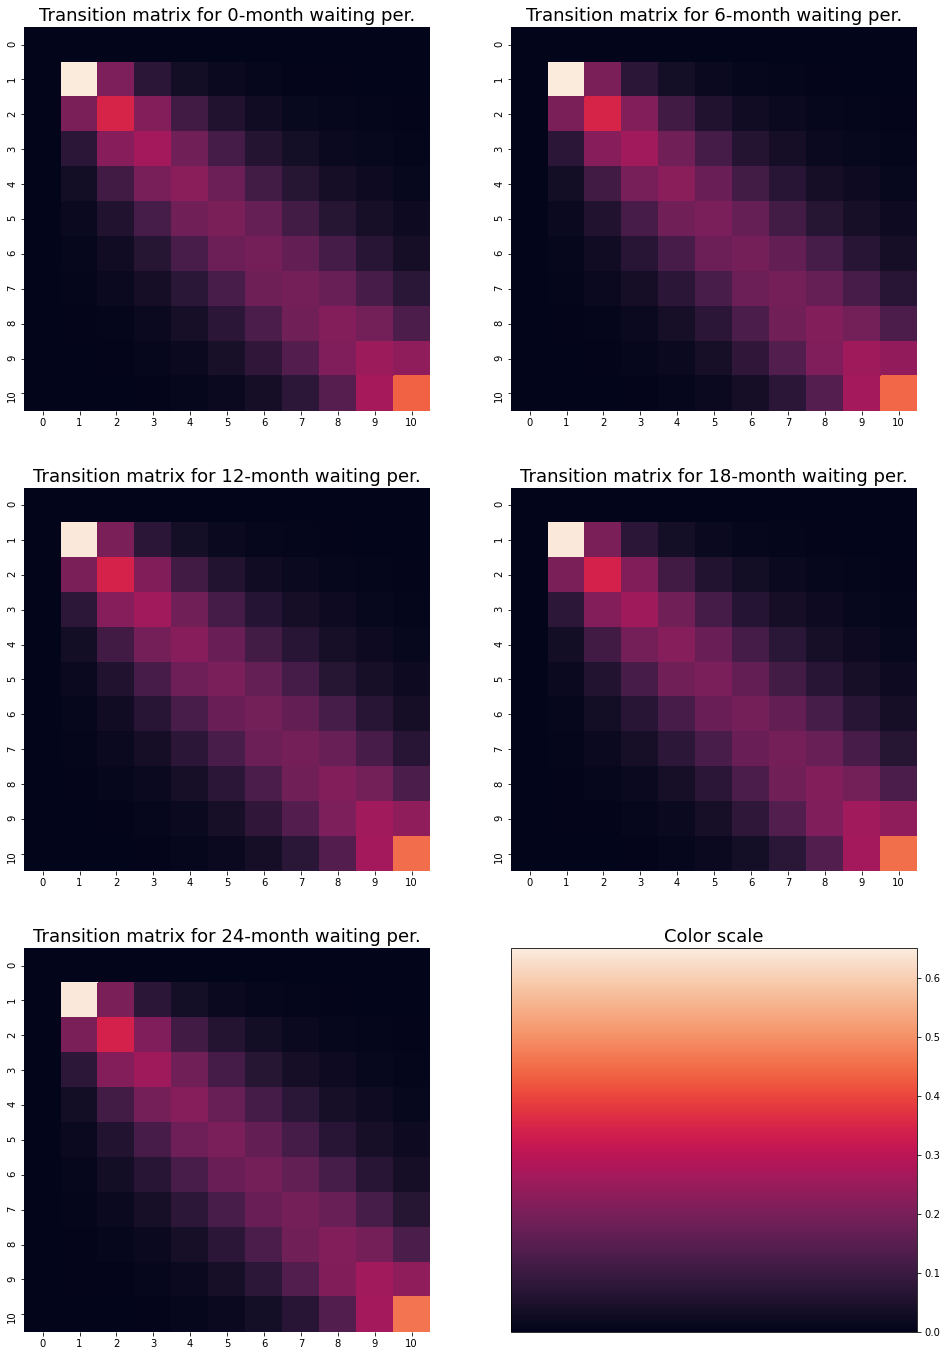

In [123]:
vmin = min([np.min(data) for data in decile_matrices])
vmax = max([np.max(data) for data in decile_matrices])
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 24))

idxs = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1), 4: (2, 0)}
for i in range(5):
    sns.heatmap(decile_matrices[i], cbar=False, ax=axes[idxs[i]], vmin=vmin, vmax=vmax)
    axes[idxs[i]].set_title(f'Transition matrix for {i * 6}-month waiting per.', fontsize=18)

fig.colorbar(axes[(0, 0)].collections[0], cax=axes[2, 1])
axes[2, 1].set_title('Color scale', fontsize=18)
    
plt.show()

In [127]:
df_new = pd.DataFrame(decile_matrices[0])
df_new.head(11)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.651347,0.206171,0.074634,0.032768,0.016017,0.008253,0.004938,0.002669,0.002113,0.001090
2,0.0,0.204628,0.347162,0.218109,0.113329,0.055987,0.028960,0.015057,0.008683,0.005108,0.002976
3,0.0,0.074535,0.223605,0.262517,0.188960,0.117403,0.062090,0.035401,0.018978,0.010222,0.006289
4,0.0,0.032100,0.112943,0.198737,0.224904,0.178237,0.115977,0.066900,0.037343,0.022597,0.010261
5,0.0,0.015360,0.056006,0.121421,0.187106,0.203970,0.171701,0.115785,0.067638,0.040309,0.020705
6,0.0,0.008204,0.029460,0.067487,0.126068,0.180592,0.194008,0.167381,0.118703,0.070592,0.037505
7,0.0,0.005194,0.015742,0.035766,0.072831,0.125023,0.180700,0.195553,0.174503,0.123314,0.071373
8,0.0,0.003479,0.007119,0.017970,0.039211,0.076303,0.129199,0.187854,0.216606,0.190964,0.131295
9,0.0,0.002227,0.004125,0.008977,0.019220,0.041556,0.081964,0.142459,0.209657,0.254330,0.235486


In [128]:
df_devs.columns

Index(['01/03/1950 - 07/03/1950', '07/03/1950 - 01/02/1951',
       '01/02/1951 - 07/02/1951', '07/02/1951 - 01/01/1952',
       '12/31/1951 - 06/30/1952', '06/30/1952 - 12/29/1952',
       '12/29/1952 - 06/29/1953', '06/29/1953 - 01/03/1954',
       '01/04/1954 - 06/28/1954', '06/28/1954 - 01/03/1955',
       ...
       '01/04/2016 - 06/27/2016', '06/27/2016 - 01/02/2017',
       '01/03/2017 - 07/03/2017', '07/03/2017 - 01/01/2018',
       '01/02/2018 - 07/02/2018', '07/02/2018 - 12/31/2018',
       '12/31/2018 - 07/01/2019', '07/01/2019 - 12/30/2019',
       '12/30/2019 - 06/29/2020', '06/29/2020 - 01/03/2021'],
      dtype='object', length=142)

## Verification

In [ ]:
df_devs

In [25]:
df_deciles.iloc[0].dropna()

07/02/2001 - 12/31/2001     1
12/31/2001 - 07/01/2002     2
07/01/2002 - 12/30/2002     1
12/30/2002 - 06/30/2003     8
06/30/2003 - 12/29/2003     5
12/29/2003 - 06/28/2004     6
06/28/2004 - 01/03/2005     8
01/03/2005 - 06/27/2005    10
06/27/2005 - 01/02/2006     9
01/03/2006 - 07/03/2006     5
07/02/2007 - 12/31/2007     5
06/30/2008 - 12/29/2008     6
12/29/2008 - 06/29/2009     2
06/29/2009 - 01/03/2010     7
01/04/2010 - 06/28/2010     1
06/28/2010 - 01/03/2011     5
01/03/2011 - 06/27/2011     1
06/27/2011 - 01/02/2012     1
01/03/2012 - 07/02/2012     3
07/02/2012 - 12/31/2012     5
12/31/2012 - 07/01/2013     2
07/01/2013 - 12/30/2013     5
12/30/2013 - 06/30/2014     7
06/30/2014 - 12/29/2014     6
12/29/2014 - 06/29/2015     4
06/29/2015 - 01/03/2016     7
01/04/2016 - 06/27/2016     3
06/27/2016 - 01/02/2017    10
01/03/2017 - 07/03/2017     1
Name: 36720410, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [27]:
trans_mat = generate_transition_mat(df_deciles)
df_trans_old = pd.DataFrame(trans_mat)

Current row: [    0. 29280.  9268.  3355.  1473.   720.   371.   222.   120.    95.
    49.]
Row sum: 44953.0
Updated row: [0.         0.65134696 0.20617089 0.07463351 0.03276756 0.01601673
 0.00825306 0.00493849 0.00266945 0.00211332 0.00109003]
---------
Current row: [    0.  9214. 15632.  9821.  5103.  2521.  1304.   678.   391.   230.
   134.]
Row sum: 45028.0
Updated row: [0.         0.20462823 0.34716177 0.21810873 0.11332948 0.05598739
 0.02895976 0.0150573  0.00868349 0.00510793 0.00297593]
---------
Current row: [    0.  3354. 10062. 11813.  8503.  5283.  2794.  1593.   854.   460.
   283.]
Row sum: 44999.0
Updated row: [0.         0.07453499 0.22360497 0.26251694 0.18895975 0.11740261
 0.06209027 0.03540079 0.0189782  0.01022245 0.00628903]
---------
Current row: [    0.  1439.  5063.  8909. 10082.  7990.  5199.  2999.  1674.  1013.
   460.]
Row sum: 44828.0
Updated row: [0.         0.03210047 0.1129428  0.1987374  0.22490408 0.17823682
 0.11597662 0.06690015 0.03734273 0.022

In [28]:
count = 0
for i, row in df_deciles.iterrows():
    # 5 to 6 - aiming for 7646
    for j in range(len(row) - 1):
        if row[j] == 5 and row[j + 1] == 6:
            count += 1
print(count)

7646


## Next steps
We're doing univariate statistics/analysis; next we'll look at pairs of companies

Big steps, then:
1. Verify Markov transition matrices
2. Go back to weekly returns, look at correlations of _weekly returns_ between each _pair of companies_ for a given _6-month period_ (not the correlations of _volatilities_, which is what we're doing now)
3. Rerank in terms of standard deviation (standard error) away from the mean; rerun Markov models
4. Look at similar analysis of _risk exposures_ - each company has a _beta_, representing its risk exposure to the market (unbounded, but usually around 1 for companies which have similar returns to the stock market)
5. Similar analysis for other types of risk exposures - not just the market, but versus oil, energy stocks, liquidity stocks, tech stocks, inflation, etc. - other time-series data  
a. Get creative - if you don't have oil prices, use oil company price movements